### Machine Learning model

**Business Problem:**
TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported - too many to be individually reviewed by a human moderator

We will build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**Business Objective:** Build a classification model to classify videos as claim or opinion

**Evaluation Metric:** 
There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim
    
It's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
df = pd.read_csv('tiktok_dataset.csv')

In [3]:
df.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [4]:
# remove rows with unknown claim_status and there are very few missing values 
#relative to the number of samples in the dataset
df.dropna(axis=0,inplace=True)

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,1.908400e+04,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9542.500000,5.624840e+09,32.423811,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5509.220604,2.537030e+09,16.226470,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4771.750000,3.425100e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9542.500000,5.609500e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14313.250000,7.840823e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19084.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [7]:
df['claim_status'].value_counts(normalize=True)
# Balanced dataset

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

### Feature Engineering 

In [8]:
df['text_length'] = df['video_transcription_text'].str.len()
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [9]:
df[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


<Axes: xlabel='text_length', ylabel='Count'>

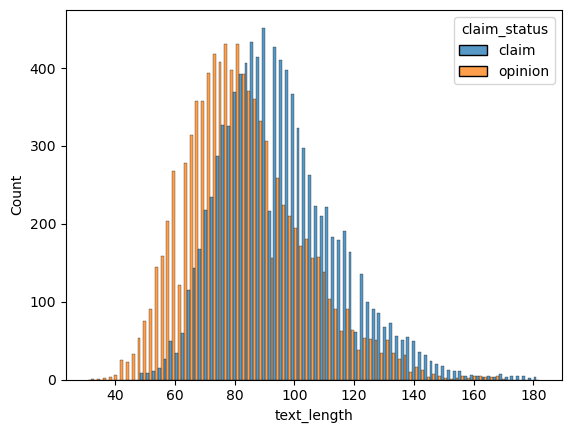

In [10]:
sns.histplot(x='text_length',data=df,hue='claim_status',multiple='dodge')

In [11]:
from scipy.stats import ttest_ind
a = df[df['claim_status']=='claim']['text_length']
b = df[df['claim_status']=='opinion']['text_length']

ttest_ind(a,b,equal_var=False)

TtestResult(statistic=44.385499339803495, pvalue=0.0, df=19071.879569012017)

From the above plot, we can see that both follow a normal distribution(consistent pattern) and on average texts classified as claims tend to be longer than the texts classified as opinions. Also we can see that the p-value<0.05 which means there is significant effect of text_length on claim_status

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19084 entries, 0 to 19083
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
 12  text_length               19084 non-null  int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 2.0+ MB


#### Feature selection and transformations

In [14]:
x = df.copy()
x = x.drop(['#','video_id'],axis=1)

# convert categorical cols to numeric
cat_col = ['author_ban_status','verified_status']
x['claim_status'] = x['claim_status'].replace({'opinion': 0, 'claim': 1})
x = pd.get_dummies(x, columns = cat_col, drop_first = True)
x.head()

/var/folders/mh/p31c9s4j7x96gcg6jjhwgmd00000gn/T/ipykernel_96370/1182589644.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x['claim_status'] = x['claim_status'].replace({'opinion': 0, 'claim': 1})


,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,author_ban_status_banned,author_ban_status_under review,verified_status_verified
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,True,False
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [15]:
# split the data into 60 20 20 ratio train val test sets
y = x['claim_status']
x = x.drop(['claim_status'],axis=1)

x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
x_train,x_val,y_train,y_val = train_test_split(x_tr,y_tr,test_size=0.25,random_state=0)

In [16]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

#### Feature Transformation

Converting the text into numeric format using CountVectorizer

Paramters :
1. ngram_range=(2, 3): Generates bigrams and trigrams.
2. max_features=15: Limits the number of features to the top 15 most frequent n-grams.
3. stop_words='english': Removes common English stop words from the text.

In [17]:
# setting up a count vectorizer
count_vec = CountVectorizer(ngram_range=(2, 3),max_features=15,stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [18]:
count_data = count_vec.fit_transform(x_train['video_transcription_text']).toarray()
count_data 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
count_vec.get_feature_names_out()
# these are the 15 most frequent bi and tri-grams seen in the train set

array(['colleague discovered', 'colleague learned', 'colleague read',
       'discovered news', 'discussion board', 'friend learned',
       'friend read', 'internet forum', 'learned media', 'media claim',
       'news claim', 'point view', 'read media', 'social media',
       'willing wager'], dtype=object)

In [20]:
# converting into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
x_train_final = pd.concat([x_train.drop(columns =['video_transcription_text']).reset_index(drop=True),count_df],axis=1)
x_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,author_ban_status_banned,author_ban_status_under review,verified_status_verified,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,True,False,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,True,False,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0,0,0,0,0,0,0,0,0,0


#### transforming text column in validation and test datasets
Notice that the vectorizer is not being refit to the validation data. It's only transforming it. In other words, the transcriptions of the videos in the validation data are only being checked against the n-grams found in the training data.

In [22]:
val_count_data = count_vec.transform(x_val['video_transcription_text']).toarray()
val_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [23]:
val_count_df = pd.DataFrame(data=val_count_data, columns=count_vec.get_feature_names_out())
val_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [24]:
x_val_final = pd.concat([x_val.drop(columns=['video_transcription_text']).reset_index(drop=True), val_count_df], axis=1)

x_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,author_ban_status_banned,author_ban_status_under review,verified_status_verified,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,True,False,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,True,False,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# transform the text in test data
test_count_data = count_vec.transform(x_test['video_transcription_text']).toarray()
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())
x_test_final = pd.concat([x_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
x_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,author_ban_status_banned,author_ban_status_under review,verified_status_verified,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,False,True,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


### Building Models

#### 1. Random Forest 
Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [26]:
# creatind a random forest
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'f1', 'recall']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [27]:
%%time
rf_cv.fit(x_train_final,y_train)

CPU times: user 3min 19s, sys: 1.2 s, total: 3min 20s
Wall time: 3min 21s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'f1', 'recall'])

In [28]:
rf_cv.best_score_

0.9948228253467271

In [29]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. Checking the precision score through validation makes sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

#### 2. XGBoost

In [30]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1']
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [31]:
%%time
xgb_cv.fit(x_train_final, y_train)

CPU times: user 2min 24s, sys: 35.1 s, total: 2min 59s
Wall time: 24.9 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [32]:
xgb_cv.best_score_

0.9898176171763818

In [33]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

#### Evaluate models against validation sets
1. Random Forest

In [42]:
y_pred = rf_cv.best_estimator_.predict(x_val_final)

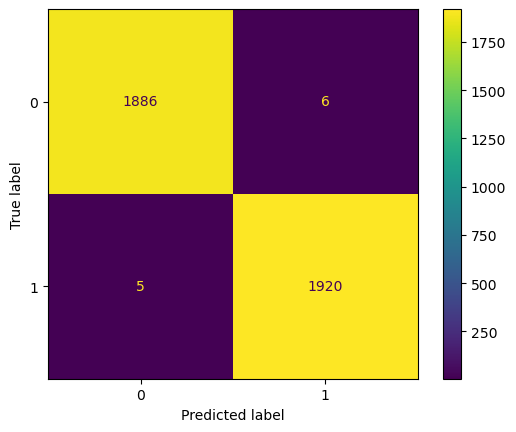

In [43]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

1. **TN(1886):** The number of opinions that the model accurately classified as so.
2. **TP(1920):** the number of claims that the model accurately classified as so.
3. **FP(6):** the number of opinions that the model misclassified as claims.
4. **FN(5):** the number of claims that the model misclassified as opinions.

In [44]:
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 10 misclassifications&mdash;five false postives and five false negatives.

2. XGBoost

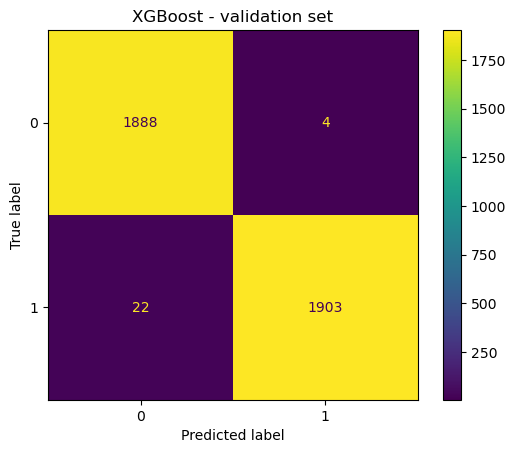

In [37]:
y_pred = xgb_cv.best_estimator_.predict(x_val_final)
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [38]:
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

#### Check Random Forest performance on test data

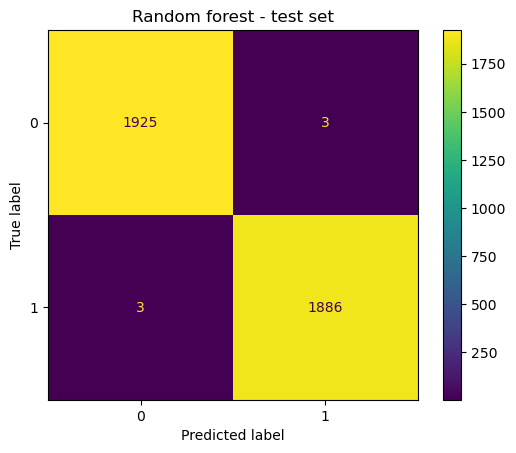

In [39]:
y_pred = rf_cv.best_estimator_.predict(x_test_final)
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

In [40]:
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1928
       claim       1.00      1.00      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



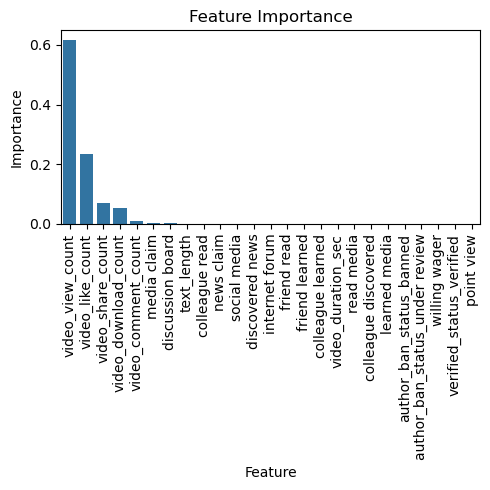

In [41]:
# Feature Importance

importance = rf_cv.best_estimator_.feature_importances_
rf_importance = pd.Series(importance, index=x_test_final.columns).sort_values(ascending=False)

plt.figure(figsize=(5,5))
sns.barplot(x=rf_importance.index, y=rf_importance.values)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()

In [46]:
rf_importance

video_view_count                  0.617822
video_like_count                  0.233684
video_share_count                 0.069042
video_download_count              0.054952
video_comment_count               0.008695
media claim                       0.002467
discussion board                  0.001997
text_length                       0.001500
colleague read                    0.001269
news claim                        0.001091
social media                      0.001045
discovered news                   0.001023
internet forum                    0.001012
friend read                       0.000980
friend learned                    0.000841
colleague learned                 0.000647
video_duration_sec                0.000606
read media                        0.000537
colleague discovered              0.000433
learned media                     0.000226
author_ban_status_banned          0.000071
author_ban_status_under review    0.000050
willing wager                     0.000004
verified_st

The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

1. This model performed well on both the validation and test holdout data. Furthermore, both precision and f1 scores were consistently high. The model very successfully classified claims and opinions.
2. The model's most predictive features were all related to the user engagement levels associated with each video.
3. The current version of the model does not need any new features as it's current performance is nearly perfect. But some new useful features might be the number of times the video was reported, the total number of user reports for all videos posted by each author.